In [31]:
import datetime, os
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
from matplotlib import pyplot as plt
from quickdraw import QuickDrawDataGroup, QuickDrawData
from pathlib import Path

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D, MaxPool2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy, SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import TensorBoard

In [2]:
image_size = (75, 75)

In [86]:
# Load 1200 training images for each class from the cloud storage
# Resize each image to 28x28 pixels
# Save the resized images in PNG format
def generate_class_images(name, max_drawings, recognized):
    directory = Path("dataset/" + name)

    if not directory.exists():
        directory.mkdir(parents=True)

    # If recognized=True is set, it guarantees that only images recognized by Google's AI will be loaded.
    images = QuickDrawDataGroup(name, max_drawings=max_drawings, recognized=recognized)
    for img in images.drawings:
        filename = directory.as_posix() + "/" + str(img.key_id) + ".png"
        img.get_image(stroke_width=3).resize(image_size).save(filename)

for label in QuickDrawData().drawing_names:
    generate_class_images(label, max_drawings=1200, recognized=True)

loading aircraft carrier drawings
load complete
loading airplane drawings
load complete
loading alarm clock drawings
load complete
loading ambulance drawings
load complete
loading angel drawings
load complete
loading animal migration drawings
load complete
loading ant drawings
load complete
loading anvil drawings
load complete
loading apple drawings
load complete
loading arm drawings
load complete
loading asparagus drawings
load complete
loading axe drawings
load complete
loading backpack drawings
load complete
loading banana drawings
load complete
loading bandage drawings
load complete
loading barn drawings
load complete
loading baseball bat drawings
load complete
loading baseball drawings
load complete
loading basket drawings
load complete
loading basketball drawings
load complete
loading bat drawings
load complete
loading bathtub drawings
load complete
loading beach drawings
load complete
loading bear drawings
load complete
loading beard drawings
load complete
loading bed drawings
l

In [3]:
# Batch size is a hyperparameter that determines the number of training examples used in one iteration
batch_size = 32 

# The dataset will be split into an 80% training set and a 20% validation set.
train_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

Found 414000 files belonging to 345 classes.
Using 331200 files for training.
Found 414000 files belonging to 345 classes.
Using 82800 files for validation.


In [3]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="dataset",target_size=(75,75))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory="dataset", target_size=(75,75))

Found 414000 images belonging to 345 classes.
Found 414000 images belonging to 345 classes.


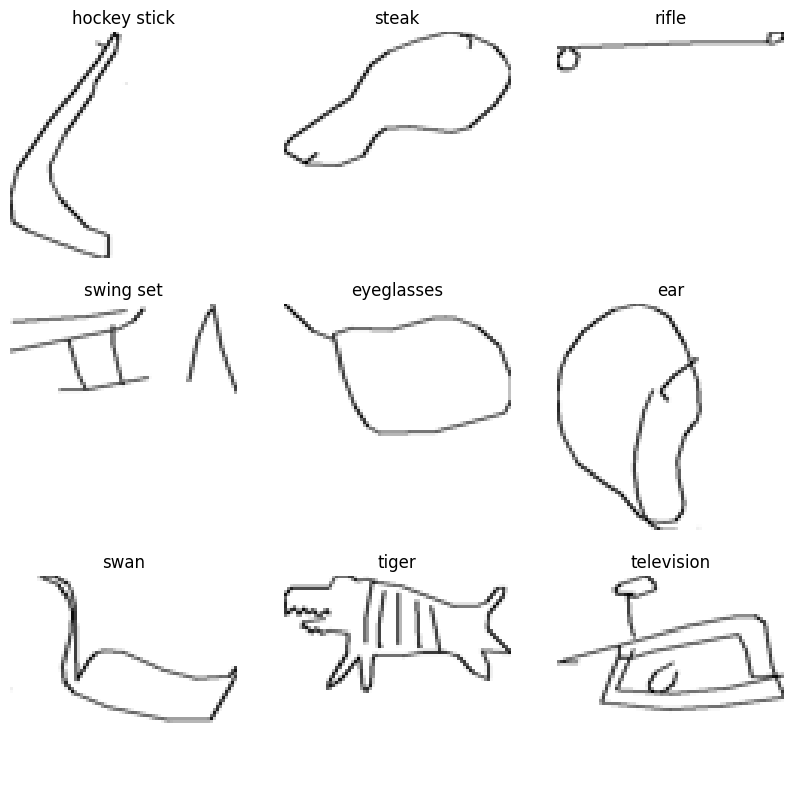

In [4]:
# plot 9 random hand drawings with its title from the training set
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        data = images[i].numpy().astype("uint8")
        plt.imshow(data, cmap='gray', vmin=0, vmax=255)
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [45]:
# input_shape = (75, 75, 3)
# inc_model = InceptionV3(include_top=False, input_shape=(input_shape))

# print("number of layers:", len(inc_model.layers))

In [31]:
# x = inc_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation="relu")(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation="relu")(x)
# predictions = Dense(2, activation="softmax")(x)

In [32]:
# # creating the final model 
# model = Model(inputs=inc_model.input, outputs=predictions)

# # Lock initial layers to do not be trained
# for layer in model.layers[:52]:
#     layer.trainable = False

# # compile the model
# model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9)
#                     , loss='categorical_crossentropy'
#                     , metrics=['accuracy'])

In [33]:
# model.summary()

In [34]:
# epochs=3

# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

# model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=epochs,
#     verbose=1,
#     callbacks=[tensorboard_callback]
# )

In [110]:
# Initializing InceptionV3 (pretrained) model with input image shape as (300, 300, 3)
base_model = VGG16(weights=None, include_top=True, input_shape=(75, 75, 3))

# Load Weights for the InceptionV3 Model
# base_model.load_weights('inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Setting the Training of all layers of InceptionV3 model to false
base_model.trainable = False

In [111]:
# Adding some more layers at the end of the Model as per our requirement
model = Sequential([
    base_model,
    # GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(5, activation='softmax') # 5 Output Neurons for 5 Classes
])

In [112]:
# # Using the Adam Optimizer to set the learning rate of our final model
# opt = optimizers.Adam(learning_rate=0.0001)
#
# # Compiling and setting the parameters we want our model to use
# model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [113]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1000)              43985704  
                                                                 
 dropout_7 (Dropout)         (None, 1000)              0         
                                                                 
 dense_16 (Dense)            (None, 1024)              1025024   
                                                                 
 dense_17 (Dense)            (None, 5)                 5125      
                                                                 
Total params: 45,015,853
Trainable params: 1,030,149
Non-trainable params: 43,985,704
_________________________________________________________________


In [114]:
epochs = 3

# steps_per_epoch = train_ds // batch_size
# validation_steps = val_ds // batch_size

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
)

# model.fit(train_ds, epochs=epochs,
#                               validation_data=val_ds)

Epoch 1/3


ValueError: in user code:

    File "C:\Users\Abderrahman\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Abderrahman\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Abderrahman\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Abderrahman\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Abderrahman\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Abderrahman\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 277, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "vgg16" "                 f"(type Functional).
    
    Input 0 of layer "block1_conv1" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 75, 75, 1)
    
    Call arguments received by layer "vgg16" "                 f"(type Functional):
      • inputs=tf.Tensor(shape=(None, 75, 75, 1), dtype=float32)
      • training=True
      • mask=None


In [4]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=2, activation="softmax"))

In [5]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 401408)            0

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
# early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
model.fit(
    traindata, 
    validation_data= testdata,
    epochs=3,
)

Epoch 1/3


In [25]:
input_shape = (75, 75, 1)
n_classes = 345

# model = Sequential()
#
# model.add(Conv2D(input_shape=(75,75,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# model.add(Flatten())
# model.add(Dense(units=4096,activation="relu"))
# model.add(Dense(units=4096,activation="relu"))
# model.add(Dense(1, activation="softmax"))

model = Sequential([
    Rescaling(1. / 255, input_shape=input_shape),
    BatchNormalization(),

    Conv2D(input_shape=(75,75,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    # Conv2D(6, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(8, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(10, kernel_size=(3, 3), padding="same", activation="relu"),
    # BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(700, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    # Dense(500, activation='relu'),
    # BatchNormalization(),
    # Dropout(0.2),
    #
    # Dense(400, activation='relu'),
    # Dropout(0.2),

    Dense(n_classes, activation='softmax')
])

In [26]:
model.compile(
    optimizer="adam",
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [27]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 75, 75, 1)         0         
                                                                 
 batch_normalization_9 (Batc  (None, 75, 75, 1)        4         
 hNormalization)                                                 
                                                                 
 conv2d_24 (Conv2D)          (None, 75, 75, 64)        640       
                                                                 
 conv2d_25 (Conv2D)          (None, 75, 75, 8)         4616      
                                                                 
 conv2d_26 (Conv2D)          (None, 75, 75, 10)        730       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 37, 37, 10)       0         
 2D)                                                  

In [28]:
epochs = 3

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback]
)

Epoch 1/3
10350/10350 [==============================] - 6566s 634ms/step - loss: 2.4474 - accuracy: 0.4354 - val_loss: 1.7827 - val_accuracy: 0.5564
Epoch 2/3
10350/10350 [==============================] - 6254s 604ms/step - loss: 1.5988 - accuracy: 0.5927 - val_loss: 1.6012 - val_accuracy: 0.5966
Epoch 3/3
10350/10350 [==============================] - 6614s 639ms/step - loss: 1.1635 - accuracy: 0.6880 - val_loss: 1.6504 - val_accuracy: 0.6000


In [30]:
# The accuracy of the model on the validation set
val_loss, val_acc = model.evaluate(val_ds)
print("Validation accuracy: ", val_acc)

# The accuracy of the model on the training set
train_loss, train_acc = model.evaluate(train_ds)
print("Training accuracy: ", train_acc)

2588/2588 [==============================] - 279s 108ms/step - loss: 1.6504 - accuracy: 0.6000
Validation accuracy:  0.6000000238418579
10350/10350 [==============================] - 1180s 114ms/step - loss: 0.7274 - accuracy: 0.8173
Training accuracy:  0.8173127770423889


1/1 [==============================] - 0s 38ms/step
Prediction:  swan
1/1 [==============================] - 0s 35ms/step
Prediction:  streetlight
1/1 [==============================] - 0s 39ms/step
Prediction:  truck
1/1 [==============================] - 0s 58ms/step
Prediction:  shorts
1/1 [==============================] - 0s 38ms/step
Prediction:  strawberry
1/1 [==============================] - 0s 34ms/step
Prediction:  crocodile
1/1 [==============================] - 0s 39ms/step
Prediction:  squirrel
1/1 [==============================] - 0s 38ms/step
Prediction:  bowtie
1/1 [==============================] - 0s 40ms/step
Prediction:  bandage


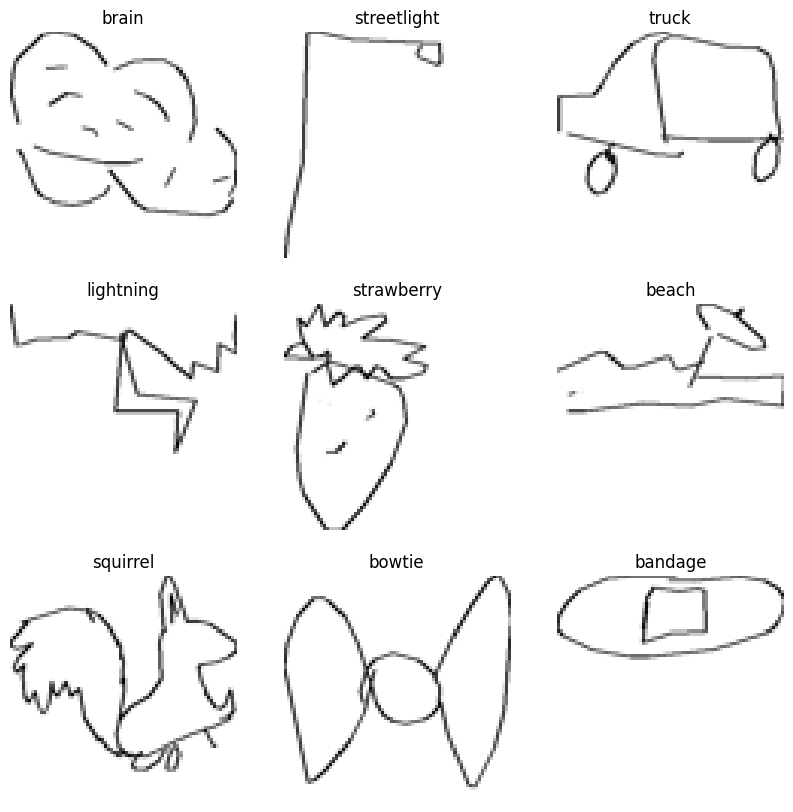

In [33]:
# plot 9 drawings from the validation set and its prediction from the model
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        data = images[i].numpy().astype("uint8")
        plt.imshow(data, cmap='gray', vmin=0, vmax=255)
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

        prediction = model.predict(images[i:i+1])
        print("Prediction: ", train_ds.class_names[tf.argmax(prediction[0])])

In [ ]:
for i in range(9)